In [68]:
#!/usr/bin/env python
# coding: utf-8
# calc_LSP_EOFs.py

import numpy as np
import pandas as pd
import geopandas as gpd
from rasterio.plot import reshape_as_raster
import xarray as xr
import rioxarray as rxr
import os
import sys
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from eofs.xarray import Eof
from copy import deepcopy

In [9]:
sys.path.insert(1, '/global/home/users/drewhart/seasonality/seasonal_asynchrony/etc/')
import phen_helper_fns as phf

In [2]:
# TODO:
  # could use clustering afterward, with scree plot, to determine K
  # distinct 'classes' of global phenological seasonality 'types'



# dataset params
dataset = 'NIRv'
masking_mode = 'default'
mask_filename_ext_dict = {'strict': '_STRICTMASK',
                          'default': ''}
mask_filename_ext = mask_filename_ext_dict[masking_mode]

# plotting params
subplots_adj_left=0.05
subplots_adj_bottom=0.1
subplots_adj_right=0.95
subplots_adj_top=0.9
subplots_adj_wspace=0.2
subplots_adj_hspace=0.4


# NOTE on memory requirements:
# I estimate that the global 365 x 2700 x 6900 raster will take up
# about 54.4 GB memory; (I could also cast of dtype float32 and cut down
# to ~27 GB). If I run this on savio bigmem that would only be ~1/9th total RAM,
# so it should be doable to create a giant global 365 x 2700 x 6900
# numpy array and then fill it with all fitted time series and write
# to disk, though that's only ~1/2 RAM on savio3, so first I'll just try there!
# Then I could separately read in as a dask array and run EOF
# analysis on that, I believe.
# Though I wonder if I could just run the EOF analysis within that
# same job. Not sure how much EOF memory requirement expands as factor
# of size of base spatiotemporal dataset, and not easily finding that
# informiation on line...


###################
# BEHAVIORAL PARAMS
###################

# min and max x and y values, to optionally subset analysis to a region
region_name = 'global'
min_x = None
max_x = None
min_y = None
max_y = None

# use hvplot, etc for interactive plotting?
interactive = False

# save figures and datasets?
save_res = True

# data dir on laptop
if os.getcwd().split('/')[1] == 'home':
    data_dir = os.path.join('/media/deth/SLAB/diss/3-phn/GEE_outputs',
                            dataset + mask_filename_ext)
# data dir on savio
else:
    data_dir = os.path.join('/global/scratch/users/drewhart/seasonality/GEE_outputs',
                            dataset + mask_filename_ext)

# set the seed
set_seed = True
if set_seed:
    seed = 1
    np.random.seed(seed)

# normalize each ts to itself?
# NOTE: it makes sense to do this, since I'm only interested in timing,
#       and otherwise (especially based on Alex Turner's results in CA) I
#       expect the first EOF will largely reflect global (i.e.,
#       cross-study-area) variation in magnitude of fitted values;
#       nonetheless, setting a flag for this so that I can check that
#       expectation and check sensitivity to this decision
normalize_ts = True

# latitude weights to use?
#lat_weights = None
#lat_weights = 'cos'
lat_weights = 'sqrt_cos'

# center the data being input to EOF?
center_eof = True

# number of top EOFs to use?
neofs = 4

# pctiles and counts of example time series to plot?
ts_top_pctile = 95
ts_bot_pctile = 95
n_ts_to_plot = 1000

In [3]:
########################################
# READ IN COEFFS, GET ARRAY OF FITTED TS
########################################

# read global NIRv coeffs
coeffs = rxr.open_rasterio(os.path.join(data_dir, '%s%s_coeffs.tif' % (dataset, mask_filename_ext)))

# subset global raster to study area (if all Nones then not subsetted!)
# NOTE: max_y and min_y flipped because y res negative in CRS transform
coeffs = coeffs.sel(x=slice(min_x, max_x), y=slice(max_y, min_y))

# get coords arrays
X, Y = np.meshgrid(coeffs.x, coeffs.y)

In [4]:
# filepath for the 365 x X x Y array of fitted time series
ts_arr_filepath = os.path.join(data_dir, f'fitted_ts_array_{dataset}{mask_filename_ext}.txt')

In [10]:
# if that file doesn't exist then create it
if not os.path.isfile(ts_arr_filepath):
    # create empty time-series array for EOF analysis
    ts_arr = np.ones((365, coeffs.shape[1], coeffs.shape[2]), dtype=np.float32) * np.nan

    # make the harmonic regression's design matrix
    dm = phf.make_design_matrix()

    # get i and j values for non-null pixels that need time series calculated
    I, J = np.where(pd.notnull(coeffs[0,:,:]))

    # get the time series for non-null pixel
    # NOTE: coeffs.shape[0] == 5, one band for each regression coeff
    for n in range(len(I)):
        i = I[n]
        j = J[n]
        coeffs_vec = coeffs[:, i, j].values
        ts = np.sum(coeffs_vec * dm, axis=1)
        # normalize time series [0,1], if desired
        # NOTE: if not, pretty certain that first EOF will largely capture
        #       global (i.e., across full subsetted extent) variation
        #       in fitted magnitude
        if normalize_ts and not np.any(np.isnan(ts)):
            ts = normalize([ts]).flatten()
        assert ts.shape == (365,)
        ts_arr[:, i, j] = ts
        if n%10000 == 0:
            print(f"\n\n\t{np.round(100*((n+1)/len(I)), 1)}% complete")
            



	0.0% complete'


	0.3% complete'


	0.6% complete'


	0.9% complete'


	1.2% complete'


	1.5% complete'


	1.8% complete'


	2.1% complete'


	2.4% complete'


	2.7% complete'


	3.0% complete'


	3.3% complete'


	3.6% complete'


	3.9% complete'


	4.2% complete'


	4.5% complete'


	4.8% complete'


	5.1% complete'


	5.4% complete'


	5.7% complete'


	6.0% complete'


	6.3% complete'


	6.6% complete'


	6.9% complete'


	7.2% complete'


	7.5% complete'


	7.8% complete'


	8.1% complete'


	8.4% complete'


	8.7% complete'


	9.0% complete'


	9.3% complete'


	9.5% complete'


	9.8% complete'


	10.1% complete'


	10.4% complete'


	10.7% complete'


	11.0% complete'


	11.3% complete'


	11.6% complete'


	11.9% complete'


	12.2% complete'


	12.5% complete'


	12.8% complete'


	13.1% complete'


	13.4% complete'


	13.7% complete'


	14.0% complete'


	14.3% complete'


	14.6% complete'


	14.9% complete'


	15.2% complete'


	15.5% complete'


	15.8% complete'


	16.1%

In [18]:
print(ts_arr.shape)

(365, 2700, 6900)


In [13]:
print(ts_arr.dtype)

float32


In [16]:
from sys import getsizeof
getsizeof(ts_arr)/1e9

27.199800136

In [20]:
print(os.path.splitext(ts_arr_filepath)[0]+'.npy')

/global/scratch/users/drewhart/seasonality/GEE_outputs/NIRv/fitted_ts_array_NIRv.npy


In [ ]:
# once complete, save this to a simple numpy array file
# (for now, anyhow; might be worth saving as a big geospatial file eventually?)
if not os.path.isfile(ts_arr_filepath) and save_res:
    print('\n\n\tNOW SAVING TIME SERIES CUBE...\n\n(this will take some time...)')
    #np.savetxt(ts_arr_filepath, ts_arr.reshape(ts_arr.shape[0], -1))
   

In [22]:
ts_arr_filepath = os.path.splitext(ts_arr_filepath)[0]+'.npy'
if not os.path.isfile(ts_arr_filepath):
    np.save(ts_arr_filepath, ts_arr)

In [23]:
# otherwise read it in
if os.path.isfile(ts_arr_filepath):
    # load saved data and reshape it from 2d to 3d
    ts_arr = np.load(ts_arr_filepath)
#     ts_arr = ts_arr_2d.reshape(ts_arr_2d.shape[0],
#                                ts_arr_2d.shape[1] // coeffs.shape[2],
#                                coeffs.shape[2])
    print(f"\n\n\tLoaded time series array Numpy file with shape {ts_arr.shape}.\n\n")



	Loaded time series array Numpy file with shape (365, 2700, 6900).




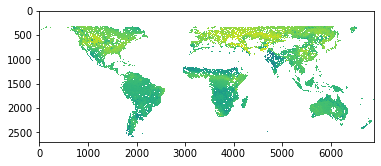

In [25]:
plt.imshow(ts_arr[160,:,:])

In [26]:
#########
# RUN EOF
#########

# calculate weights array requested
if lat_weights == 'cos':
    weights = np.cos(np.deg2rad(Y))
    weights /= weights.mean()
elif lat_weights == 'sqrt_cos':
    weights = np.sqrt(np.cos(np.deg2rad(Y)))
    weights /= weights.mean()
else:
    weights = None

# coerce ts array to rio xarray obj
ts_da = xr.DataArray([coeffs[0,:,:]*np.nan]*365)
ts_da.attrs = coeffs.attrs
ts_da.attrs['long_name'] = ['d%i' % i for i in range(1, 366)]
ts_da = ts_da.rename({'dim_0': 'time',
                      'dim_1': 'y',
                      'dim_2': 'x',
                      })
ts_da = ts_da.assign_coords({'time': range(1, 366),
                             'y': coeffs.y.values,
                             'x': coeffs.x.values,
                             })
ts_da = ts_da.rio.write_crs(4326)
ts_da.rio.set_crs(4326)
ts_da.loc[:,:,:] = ts_arr

# use empirical orthogonal functions to collapse global ts into
# main modes of variation
solver = Eof(ts_da, weights=weights)

In [71]:
?Eof

In [27]:
print('EOFs calculated!')

EOFs calculated!


In [28]:
# grab the first n EOFs
# (and swap axes so that 3rd axis is of length neofs, to facilitate image
# plotting)
eofs = solver.eofsAsCorrelation(neofs=neofs)

# grab the PCs
pcs = solver.pcs(npcs=neofs, pcscaling=1)

# grab pct variances of EOFs
var_pcts = solver.varianceFraction(neofs)

# reconstruct the field using just the selected top EOFs
ts_recon = solver.reconstructedField(neofs)

# write eofs to file, if requested
if save_res:
    tif_filename = '%s_%s_%i_EOFs_%s%s%s.tif' % (dataset,
                                                 region_name,
                                                 neofs,
                                                 lat_weights + 'wts',
                                                 '_normts' * normalize_ts,
                                                 mask_filename_ext,
                                                  )
    eof_res_for_file = eofs.to_dataset('mode')
    eof_res_for_file = eof_res_for_file.rename_vars(
                                    {i: 'eof%i' % i for i in range(neofs)})
    eof_res_for_file.rio.to_raster(os.path.join(data_dir, tif_filename),
                       dtype=np.float32,
                       tags={'eof%i_pctvar' % i:
                             str(var_pcts.values[i]) for i in range(neofs)},
                      )

In [29]:
print('EOFs saved!')

EOFs saved!


In [40]:
def minmax_scale_arr(arr):
    return (arr - np.nanmin(arr))/(np.nanmax(arr) - np.nanmin(arr))

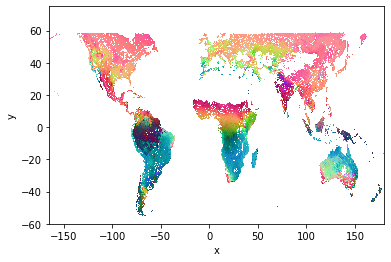

In [41]:
minmax_scale_arr(eofs[:3, :, :]).plot.imshow()

[77.71594, 13.236502, 5.9601717, 3.087385, 3.3269252e-11, 2.969775e-15, 2.966193e-15, 2.9639555e-15, 2.9586497e-15, 2.9560444e-15]


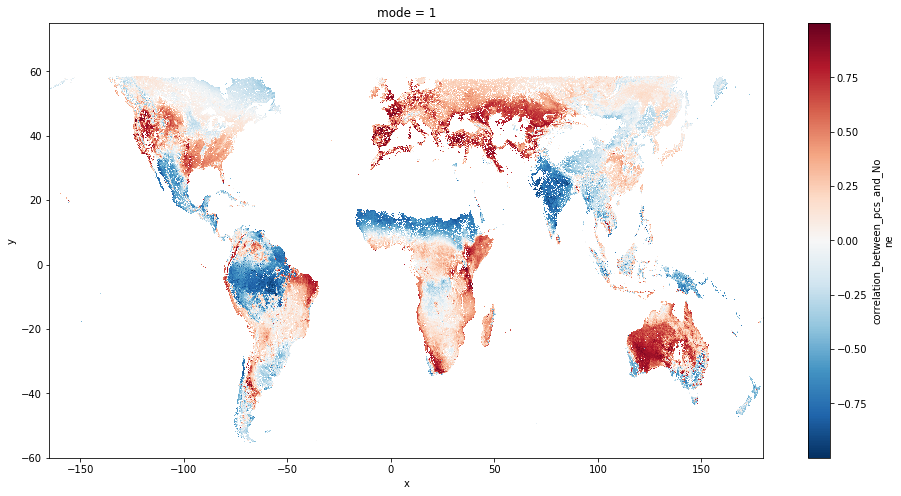

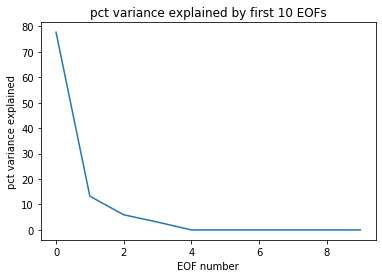

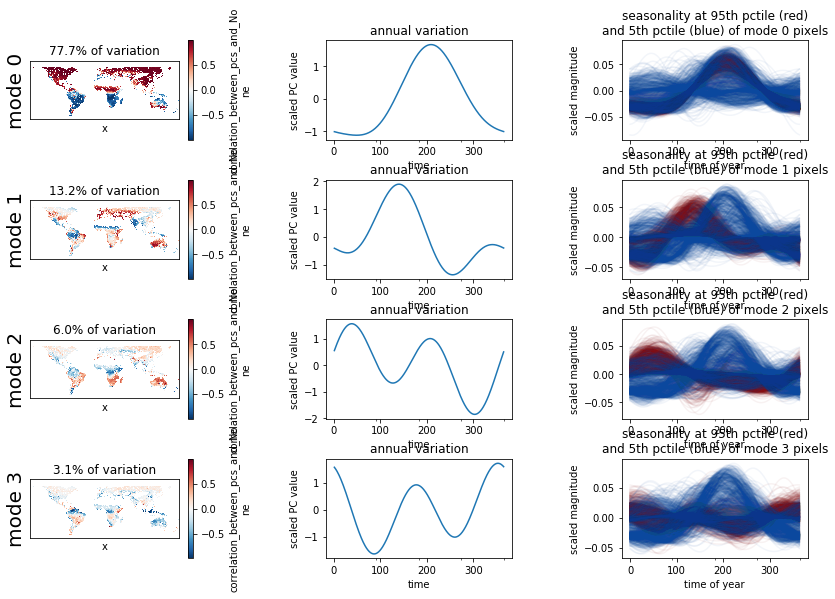

In [43]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
eofs.sel(mode=1).plot.imshow(ax=ax)

fig, ax = plt.subplots(1,1)
ax.plot(solver.varianceFraction(10)*100)
ax.set_title('pct variance explained by first 10 EOFs')
ax.set_xlabel('EOF number')
ax.set_ylabel('pct variance explained')
print([*solver.varianceFraction(10).values*100])


#########################################################################
# MAP AND PLOT CHARACTERISTIC SEASONAL PATTERNS AT ENDS OF EACH EOF RANGE
#########################################################################

fig = plt.figure(figsize=(12,9))
gs = fig.add_gridspec(nrows=neofs, ncols=5, width_ratios=[1,0.3,1,0.3,1])
for neof in range(neofs):
    ax_map = fig.add_subplot(gs[neof, 0])
    eofs.sel(mode=neof).plot.imshow(ax=ax_map)
    ax_map.set_aspect('equal')
    ax_map.set_xticks(())
    ax_map.set_yticks(())
    ax_map.set_xticklabels(())
    ax_map.set_yticklabels(())
    ax_map.set_ylabel('mode %i' % neof, fontdict={'fontsize': 20})
    ax_map.set_title('%0.1f%% of variation' % (var_pcts[neof]*100))
    ax_pc_plot = fig.add_subplot(gs[neof,2])
    ax_pc_plot.set_xlabel('time of year')
    ax_pc_plot.set_xticks(np.linspace(0, 365, 5), ['Jan', 'Apr', 'Jul',
                                                   'Oct', 'Jan'])
    pcs.sel(mode=neof).plot(ax=ax_pc_plot)
    ax_pc_plot.set_title('annual variation')
    ax_pc_plot.set_ylabel('scaled PC value')
    ax_examp_ts = fig.add_subplot(gs[neof,4])
    top_ts = ts_recon.values[:,
        eofs.sel(mode=neof)>=np.nanpercentile(eofs.sel(mode=neof), ts_top_pctile)].T
    idxs_to_plot = np.random.choice(range(top_ts.shape[0]), size=n_ts_to_plot, replace=False)
    ts_to_plot = top_ts[idxs_to_plot,:]
    for ts in ts_to_plot:
        ax_examp_ts.plot(range(365), ts, alpha=0.05, color='#850c10')
    bot_ts = ts_recon.values[:,
        eofs.sel(mode=neof)<=np.nanpercentile(eofs.sel(mode=neof), ts_bot_pctile)].T
    idxs_to_plot = np.random.choice(range(bot_ts.shape[0]), size=n_ts_to_plot, replace=False)
    ts_to_plot = bot_ts[idxs_to_plot,:]
    for ts in ts_to_plot:
        ax_examp_ts.plot(range(365), ts, alpha=0.05, color='#0b489e')
    ax_examp_ts.set_xlabel('time of year')
    ax_examp_ts.set_ylabel('scaled magnitude')
    ax_examp_ts.set_title(('seasonality at 95th pctile (red)\n'
                        'and 5th pctile (blue) of mode %i pixels') % neof)
    ax_examp_ts.set_xticks(np.linspace(0, 365, 5), ['Jan', 'Apr', 'Jul',
                                                    'Oct', 'Jan'])
fig.subplots_adjust(left=subplots_adj_left,
                     bottom=subplots_adj_bottom,
                     right=subplots_adj_right,
                     top=subplots_adj_top,
                     wspace=subplots_adj_wspace,
                     hspace=subplots_adj_hspace)
fig.show()
if save_res:
    fig_filename = '%s_%s_EOF_results_scat_%s%s%s.png' % (dataset,
                                                            region_name,
                                                            lat_weights + 'wts',
                                                            '_normts' * normalize_ts,
                                                            mask_filename_ext,
                                                           )
    fig.savefig(os.path.join(data_dir, fig_filename), dpi=500)

In [ ]:
# create EOF fig
supp_fig_eof = plt.figure(figsize=(20,30))

# make maps of EOFS 1, 2, and 3 (all raw)
eofs_for_map = eofs.rio.write_crs(4326).reproject(8857)
for i in range(3):
    ax_eof = fig_eof.add_subplot(3,1,i+1)
    eofs_for_map[i] = eofs_for_map[i].where(
            eofs_for_map[i] < 2*eofs[i].max(), np.nan)
    eofs_for_map[i].plot.imshow(ax=ax_eof,
                                cmap='coolwarm',
                                add_colorbar=False,
                                alpha=1,
                                zorder=0,
                               )
    subnational.plot(color='none',
                     linewidth=0.3,
                     edgecolor='black',
                     alpha=0.5,
                     ax=ax_eof,
                     zorder=1,
                    )
    countries.plot(color='none',
                   linewidth=0.5,
                   edgecolor='black',
                   alpha=0.7,
                   ax=ax_eof,
                   zorder=2,
                  )

    strip_axes(ax_eof)
    ax_eof.set_xlim(global_xlim)
    ax_eof.set_ylim(eofs_for_map.rio.bounds()[1::2])
    ax_eof.text(0.92*ax_eof.get_xlim()[0], 0.92*ax_eof.get_ylim()[0],
                'EOF %i\n%0.1f%%' % (i+1, eofs_pcts[i]),
                fontdict={'fontsize': 38})
del eofs_for_map
fig_eof.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.98,
                        hspace=0.05)
if save_it:
    fig_eof.savefig('FIG_S1_%s_EOF_maps%s%s.png' % (dataset,
                mask_filename_ext, ('_RAW'*(not fold_it))), dpi=600)




In [54]:
float(np.round(var_pcts[0]*100, 2))

77.72

In [58]:
# save PC table, for use in supplemental figure
pc_dict = {f"EOF{neof}_{float(np.round(var_pcts[neof]*100, 2))}pct": pcs.sel(mode=neof).values for neof in range(4)}
pc_df = pd.DataFrame.from_dict(pc_dict)
pc_df_filepath = os.path.join(data_dir, f'{dataset}{mask_filename_ext}_EOF_PC_table.csv')
pc_df.to_csv(pc_df_filepath, index=False)

Text(0, 0.5, 'pct variance explained')

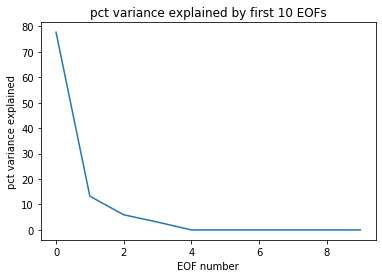

In [60]:
fig, ax = plt.subplots(1,1)
ax.plot(solver.varianceFraction(10)*100)
ax.set_title('pct variance explained by first 10 EOFs')
ax.set_xlabel('EOF number')
ax.set_ylabel('pct variance explained')

In [64]:
from sklearn.cluster import MiniBatchKMeans

eofs_vals = eofs[:3, :, :].values.swapaxes(0,1).swapaxes(1,2)
eofs_X = eofs_vals.reshape([np.product(eofs_vals.shape[:2]), 3])
eofs_non_nans = np.where(np.sum(np.isnan(eofs_X), axis=1) == 0)[0]
eofs_X_sub = eofs_X[eofs_non_nans, :]

res = {K: {} for K in range(1, 11)}
batch_size = 40
n_init = 10
max_no_improvement = 10
for K in range(1, 11):
    clust = MiniBatchKMeans(init='k-means++',
                            n_clusters=K,
                            batch_size=batch_size,
                            n_init=n_init,
                            max_no_improvement=max_no_improvement,
                            verbose=0,
                           )
    clust.fit(eofs_X_sub)
    res[K]['inertia'] = clust.inertia_
    res[K]['centers'] = clust.cluster_centers_
    res[K]['labels'] = clust.labels_
    

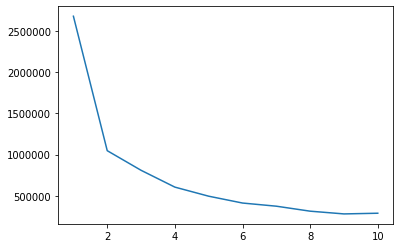

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([K for K in res], [v['inertia'] for v in res.values()])

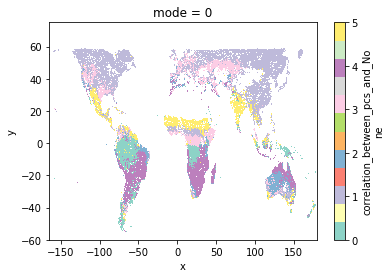

In [70]:
K = 6
cluster_arr = np.ones([eofs_X.shape[0], 1])*np.nan
cluster_arr[eofs_non_nans,0] = res[K]['labels']                                                                                                                                                                                                             
clusters = cluster_arr.reshape(eofs_vals[:,:,0].shape)
clusters_rxr = deepcopy(eofs[0])
clusters_rxr[:,:] = clusters
clusters_rxr.plot.imshow(cmap='Set3', add_colorbar=True)